This notebook produces the figures and analysis for figure 3 and accompanying supplemental materials

In [54]:
#setup

import os, sys, csv
import pandas as pd
import numpy as np
from scipy.stats import norm #for stouffer's method of combining p-values


#plotting packages
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

#module for loading genome/genes
from fetch_genes import fetch_sequence, extract_gene_info

#for gene annotation
from intervaltree import IntervalTree
from bisect import bisect_right

#for parallel processing
#import time
from joblib import Parallel, delayed
from tqdm import tqdm

#for multiple testing correction
from statsmodels.stats.multitest import multipletests

#input directories
pwd = os.getcwd()
data_dir = os.path.join(pwd,"biobloomrxiv_source_data") #


#output directories, configure as needed
dir_pwd = os.path.dirname(pwd)
fig3out = os.path.join(dir_pwd,"figures","fig3")

In [8]:
# load dataframe of all observed donors and their counts. These donors are already parsed for mutations
#note that csv is large, takes ~30 seconds to load
donor_muts_path = os.path.join(data_dir, "parsed_donors.csv") #replace with parquet
donor_muts = pd.read_csv(donor_muts_path)

#filter our rows where pos_donor is not between 38 and 42
#this removes mutations that are not "intended" at the "N" synthesis position
donor_muts_clean = donor_muts.copy()
donor_muts_clean['pos_donor'] = donor_muts_clean['pos_donor'].astype(int)
donor_muts_clean = donor_muts_clean[donor_muts_clean['pos_donor'].between(39, 41)]

#then, combine evidence for mutations across donors
# this turns donors annotated with mutations, into mutations with counts
all_mutations_df = (
    donor_muts_clean #clean version
    .groupby(["pos", "ref", "alt","samplenum"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "all_count"})
)
all_mutations_df



,pos,ref,alt,samplenum,all_count
0,46,A,G,5,14
1,48,A,T,5,17
2,49,A,G,4,19
3,115,T,C,1,11
4,115,T,G,1,12
...,...,...,...,...,...
10579745,4641568,C,G,4,11
10579746,4641569,G,C,6,15
10579747,4641570,A,C,1,19
10579748,4641571,G,T,4,10


In [9]:
##FYI
#40, 41, and 39 cover the majority of mutation positions
print(donor_muts['pos_donor'].value_counts())

#approximately 62% of donors are covered by the 39-41 range
print(len(donor_muts_clean)/len(donor_muts))



pos_donor
40     6532925
41     5989122
39     1025031
38      383347
82      298635
        ...   
157          1
101          1
144          1
164          1
109          1
Name: count, Length: 131, dtype: int64
0.6229387373835169


In [10]:
#for some summary stats, need to have metadata like conditions, timepoint, etc
metadat_path = os.path.join(data_dir, "fullgenome_metadata_tidy.csv")
metadat = pd.read_csv(metadat_path)
metadat["samplenum"]= metadat["Sample_ID"]
metadat.drop("Sample_ID", axis=1, inplace=True)


all_mutations_df_annot = pd.merge(all_mutations_df, metadat, on= "samplenum")

#free up memory
del donor_muts
del donor_muts_clean
del all_mutations_df
import gc
gc.collect()

#save to disk, to save time on re-loading
all_mutations_df_annot.to_parquet(
    os.path.join(data_dir, "all_mutations_clean_annot.parquet"),
    engine='pyarrow',
    compression='snappy',
    index=False
)

#all_mutations_df_annot.to_csv(os.path.join(data_dir, "all_mutations_clean_annot.csv"), index=False)
all_mutations_df_annot

,pos,ref,alt,samplenum,all_count,tx_name,selection_type,rep,time_day,notes,preex_hit
0,46,A,G,5,14,56,none,B,0,Induced cultures,y
1,48,A,T,5,17,56,none,B,0,Induced cultures,y
2,49,A,G,4,19,56,none,A,0,Induced cultures,y
3,115,T,C,1,11,1234,none,A,0,Induced cultures,n
4,115,T,G,1,12,1234,none,A,0,Induced cultures,n
...,...,...,...,...,...,...,...,...,...,...,...
10579745,4641568,C,G,4,11,56,none,A,0,Induced cultures,y
10579746,4641569,G,C,6,15,56,none,C,0,Induced cultures,y
10579747,4641570,A,C,1,19,1234,none,A,0,Induced cultures,n
10579748,4641571,G,T,4,10,56,none,A,0,Induced cultures,y


In [ ]:
#fetch genome information, for gene-level annotation
#these functions are in the fetch_genes.py module

#Fetch genome and extract gene coordinates
record = fetch_sequence("U00096.3")
gene_df = extract_gene_info(record)



In [ ]:
### for annotating genes and intergenic regions
#this function uses interval trees to make the lookup fast
#it depends on the gene_df dataframe, which is generated in block above using the fetch_genes.py module


# Pre-sort gene intervals for efficient lookup
sorted_genes = gene_df.sort_values("Start").reset_index(drop=True)
gene_starts = sorted_genes["Start"].values
gene_ends = sorted_genes["End"].values
gene_names = sorted_genes["Gene"].values


# Build interval tree once from gene_ranges
gene_tree = IntervalTree()
for _, row in gene_df.iterrows():
    gene_tree[row['Start']:row['End'] + 1] = row['Gene']  # inclusive end


def fast_annotate(pos):
    matches = gene_tree[pos]
    if matches:
        return list(matches)[0].data  # In a gene

    # Position is intergenic — find surrounding genes
    idx = bisect_right(gene_starts, pos)

    if idx == 0:
        # Before first gene
        return f"intergenic_before_{gene_names[0]}"
    elif idx >= len(gene_starts):
        # After last gene
        return f"intergenic_after_{gene_names[-1]}"
    else:
        # Between two genes
        upstream_gene = gene_names[idx - 1]
        downstream_gene = gene_names[idx]
        return f"intergenic_between_{upstream_gene}_and_{downstream_gene}"

In [ ]:
# we use a permutation test to determine the significance of each mutation, a proxy for enrichment/selection

#define a function for permutation tests, with parallel functionality
def empirical_pval(obs, null_dist):
    """Compute one-tailed empirical p-value"""
    return (np.sum(null_dist >= obs) + 1) / (len(null_dist) + 1)

def process_row(obs_value, null_dist):
    return empirical_pval(obs_value, null_dist)

def compute_empirical_pvals(df, value_col='all_count', null_size=10000, subsample=True, n_jobs=-1, random_state=42):
    """Compute empirical p-values for each row in df using permutation-style test."""
    np.random.seed(random_state)
    all_values = df[value_col].values
    if subsample:
        null_dist = np.random.choice(all_values, size=null_size, replace=True)
    else:
        null_dist = all_values  # Use full dataset as null
    print(f"Using null distribution of size: {len(null_dist)}")
    # Compute in parallel
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(obs, null_dist) for obs in tqdm(all_values)
    )
    return pvals

In [17]:
### to combine p-values across replicates, we use Stouffer's method
tqdm.pandas()  # enables .progress_apply

def stouffer_combination(pvals):
    """Combine p-values using Stouffer's method"""
    z_scores = norm.isf(pvals)  # inverse survival function = Φ⁻¹(1 - p)
    z_combined = np.sum(z_scores) / np.sqrt(len(z_scores))
    return norm.sf(z_combined)  # one-sided p-value


def stouffer_wrapper(group, pval_col='permutation_pval_precise', count_col='all_count', output_col='stouffer_pval'):
    pvals = group[pval_col].values
    all_counts = group[count_col].tolist()  # Collect all_count values in a list
    return pd.Series({
        output_col: stouffer_combination(pvals),
        'rep_count': len(pvals),
        'all_counts': all_counts  # Store as a list
    })




In [ ]:
###setup for adding gene cartoons to plots

def plot_gene_cartoon(
    gene_name, gene_info_df, padding=500, y_position=0, arrow_color='green', arrow_edge='blue',
    label_offset=0.1, arrow_width=10, arrow_headwidth=20, arrow_headlength=30, gene_name_fontsize=10
):
    """
    Plots a gene cartoon as an arrow, with direction based on the strand (+ or -), and labels the gene.

    Parameters:
    - gene_name: str, name of the gene to plot.
    - gene_info_df: pandas DataFrame, must contain 'Gene', 'Start', 'End', and 'Strand' columns.
    - padding: int, padding around the gene start and end positions.
    - y_position: int or float, y-axis position for the arrow.
    - arrow_color: str, color of the arrow body.
    - arrow_edge: str, color of the arrow edge.
    - label_offset: float, vertical offset for the gene name label.
    """
    # Find the gene in the DataFrame
    gene_row = gene_info_df[gene_info_df['Gene'] == gene_name]
    if gene_row.empty:
        raise ValueError(f"Gene '{gene_name}' not found in the provided DataFrame.")
    
    start = gene_row['Start'].values[0]
    end = gene_row['End'].values[0]
    strand = gene_row['Strand'].values[0]
    
    # Determine the arrow direction
    if strand == "+":
        arrow_start, arrow_end = start, end
    elif strand == "-":
        arrow_start, arrow_end = end, start
    else:
        raise ValueError(f"Invalid strand value '{strand}' for gene '{gene_name}'.")

    # Plot the gene as an arrow
    #plt.xlim(min(start, end) - padding, max(start, end) + padding)  # Set x-axis limits
    plt.annotate(
        '', xy=(arrow_end, y_position), xytext=(arrow_start, y_position),
        arrowprops=dict(facecolor=arrow_color, edgecolor=arrow_edge, width=arrow_width, headwidth=arrow_headwidth, headlength=arrow_headlength)
    )
    
    # Add the gene name label
    plt.text(
        x=(start + end) / 2,  # Midpoint of the arrow
        y=y_position + label_offset,  # Slightly above the arrow
        s=gene_name,  # Label text
        color="black",  # Label color
        fontsize=gene_name_fontsize,  # Font size
        ha="center"  # Center alignment
    )

#this modification accommodates genes that extend beyond the plot limits
def plot_gene_cartoon_clipped(
    gene_name, gene_info_df, padding=500, y_position=0, arrow_color='green', arrow_edge='blue',
    label_offset=0.1, arrow_width=10, arrow_headwidth=20, arrow_headlength=30, gene_name_fontsize=10
):
    """
    Plots a gene cartoon as an arrow, with direction based on the strand (+ or -), and labels the gene.
    Now handles cases where the gene extends beyond plot limits by creating truncated/broken arrows.

    Parameters:
    - gene_name: str, name of the gene to plot.
    - gene_info_df: pandas DataFrame, must contain 'Gene', 'Start', 'End', and 'Strand' columns.
    - padding: int, padding around the gene start and end positions.
    - y_position: int or float, y-axis position for the arrow.
    - arrow_color: str, color of the arrow body.
    - arrow_edge: str, color of the arrow edge.
    - label_offset: float, vertical offset for the gene name label.
    """
    # Find the gene in the DataFrame
    gene_row = gene_info_df[gene_info_df['Gene'] == gene_name]
    if gene_row.empty:
        raise ValueError(f"Gene '{gene_name}' not found in the provided DataFrame.")
    
    start = gene_row['Start'].values[0]
    end = gene_row['End'].values[0]
    strand = gene_row['Strand'].values[0]
    
    # Get current plot limits
    ax = plt.gca()
    xlim = ax.get_xlim()
    x_min, x_max = xlim[0], xlim[1]
    
    # Determine the arrow direction
    if strand == "+":
        arrow_start, arrow_end = start, end
    elif strand == "-":
        arrow_start, arrow_end = end, start
    else:
        raise ValueError(f"Invalid strand value '{strand}' for gene '{gene_name}'.")
    
    # Check if gene is completely outside plot limits
    if arrow_end < x_min or arrow_start > x_max:
        # Gene is completely outside plot - don't draw anything
        return
    
    # Clip the arrow to plot limits
    clipped_start = max(arrow_start, x_min)
    clipped_end = min(arrow_end, x_max)
    
    # Determine what to draw based on clipping
    if clipped_start < x_min and clipped_end > x_max:
        # Gene spans entire plot - draw full arrow
        plt.annotate(
            '', xy=(arrow_end, y_position), xytext=(arrow_start, y_position),
            arrowprops=dict(facecolor=arrow_color, edgecolor=arrow_edge, 
                          width=arrow_width, headwidth=arrow_headwidth, headlength=arrow_headlength)
        )
    elif clipped_start < x_min:
        # Gene starts before plot - draw truncated arrow from left edge
        plt.annotate(
            '', xy=(clipped_end, y_position), xytext=(x_min, y_position),
            arrowprops=dict(facecolor=arrow_color, edgecolor=arrow_edge, 
                          width=arrow_width, headwidth=arrow_headwidth, headlength=arrow_headlength)
        )
        # Add "broken" indicator on the left
        plt.plot([x_min, x_min + 50], [y_position - arrow_width/2, y_position + arrow_width/2], 
                color=arrow_edge, linewidth=2)
    elif clipped_end > x_max:
        # Gene ends after plot - draw truncated arrow to right edge
        plt.annotate(
            '', xy=(x_max, y_position), xytext=(clipped_start, y_position),
            arrowprops=dict(facecolor=arrow_color, edgecolor=arrow_edge, 
                          width=arrow_width, headwidth=arrow_headwidth, headlength=arrow_headlength)
        )
        # Add "broken" indicator on the right
        plt.plot([x_max - 50, x_max], [y_position - arrow_width/2, y_position + arrow_width/2], 
                color=arrow_edge, linewidth=2)
    else:
        # Gene is fully within plot - draw normal arrow
        plt.annotate(
            '', xy=(clipped_end, y_position), xytext=(clipped_start, y_position),
            arrowprops=dict(facecolor=arrow_color, edgecolor=arrow_edge, 
                          width=arrow_width, headwidth=arrow_headwidth, headlength=arrow_headlength)
        )
    
    # Add the gene name label (only if gene is partially visible)
    if clipped_start < x_max and clipped_end > x_min:
        label_x = (clipped_start + clipped_end) / 2  # Midpoint of visible portion
        plt.text(
            x=label_x,
            y=y_position + label_offset,
            s=gene_name,
            color="black",
            fontsize=gene_name_fontsize,
            ha="center"
        )



In [21]:
### permutation test to apply p-values to barcode frequencies after rifampicin selection
rif_stats = all_mutations_df_annot.copy()
rif_stats = rif_stats[(rif_stats['time_day']==1) & (rif_stats['tx_name']==1234) & (rif_stats['selection_type']=='rif')] #545k rows
rif_stats['permutation_pval_precise'] = compute_empirical_pvals(rif_stats, value_col='all_count', subsample=False)
rif_combined_df = rif_stats.groupby(['pos', 'ref', 'alt']).progress_apply(stouffer_wrapper, pval_col='permutation_pval_precise').reset_index()

# label genes, using fast method
rif_combined_df['Gene'] = rif_combined_df['pos'].apply(fast_annotate)
rif_combined_df['-log10(pval)'] = -np.log10(rif_combined_df['stouffer_pval'])


rif_combined_df #375k rows

Using null distribution of size: 443255


100%|██████████| 289640/289640 [02:28<00:00, 1945.33it/s]


,pos,ref,alt,stouffer_pval,rep_count,all_counts,Gene,-log10(pval)
0,129,A,T,0.635324,1,[15],intergenic_before_thrL,0.197005
1,149,A,T,0.195384,2,"[42, 24]",intergenic_before_thrL,0.709111
2,161,G,A,0.744520,1,[13],intergenic_before_thrL,0.128124
3,162,A,G,0.462378,1,[20],intergenic_before_thrL,0.335002
4,163,T,A,0.813819,1,[12],intergenic_before_thrL,0.089472
...,...,...,...,...,...,...,...,...
289635,4640939,A,G,0.635324,1,[15],intergenic_between_ytjE_and_yjtD,0.197005
289636,4640941,A,G,0.897540,1,[11],yjtD,0.046946
289637,4640941,A,T,0.635324,1,[15],yjtD,0.197005
289638,4641211,C,A,0.635324,1,[15],yjtD,0.197005


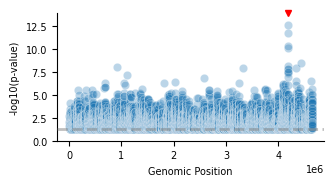

In [23]:
### take a look at rif selection, genome-wide
#this does not yet use adjusted p-values, which we will do below

# Apply filters
pval_cutoff = 0.05
into_plot = rif_combined_df[(rif_combined_df['rep_count']==3)&(rif_combined_df['stouffer_pval']<pval_cutoff)]


# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(pval)',
    kind="scatter",
    height=2,
    aspect=1.7,
    alpha=0.3
)

g.set_axis_labels("Genomic Position", "-log10(p-value)", fontsize = 7)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=14)
    ax.xaxis.offsetText.set_fontsize(7)
    ax.tick_params(labelsize=7)
    #ax.set_xticks([xlim_start, xlim_end])
    #ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}E6'))
    ax.plot(4182100, 14, marker='v', color='red', markersize=5, clip_on=False, zorder=10) #~middle rpoB
    #add threshold line
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)


#g.savefig(os.path.join(fig3out, f"rif_selection_pval{pval_cutoff}.png"), dpi=300, bbox_inches='tight')

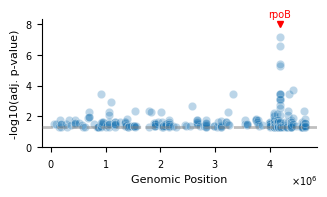

In [33]:
#use benjamini hochberg correction to look at adjusted p-values

rif_combined_df['BH_pval'] = multipletests(rif_combined_df['stouffer_pval'], method='fdr_bh')[1]
rif_combined_df['-log10(BH_pval)'] = -np.log10(rif_combined_df['BH_pval'])


#plot with BH corrected pvals

# Apply filters
pval_cutoff = 0.05
into_plot = rif_combined_df[(rif_combined_df['BH_pval']<0.05)]


# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(BH_pval)',
    kind="scatter",
    height=2,
    aspect=1.7,
    alpha=0.3
)

fontsize = 8
g.set_axis_labels("Genomic Position", "-log10(adj. p-value)", fontsize = fontsize)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=8+0.3)
    ax.xaxis.offsetText.set_fontsize(fontsize-1)
    ax.tick_params(labelsize=7)
    #ax.set_xticks([xlim_start, xlim_end])
    #ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}E6'))
    ax.plot(4182100, 8, marker='v', color='red', markersize=5, clip_on=False, zorder=10) #~middle rpoB
    ax.text(4182100, 8 + 0.3, "rpoB", color='red', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    #add threshold line
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)
    #customize x-axis formatter
    ax.ticklabel_format(axis="x", style="sci", scilimits=(6, 6))
    ax.xaxis.get_major_formatter().set_useMathText(True)


g.savefig(os.path.join(fig3out, f"rif_selection_adjpval{pval_cutoff}.png"), dpi=600, bbox_inches='tight')

In [ ]:
#for rpoB, import set of literature rifampicin resistance mutations

#import set of literature mutations
literature_muts_df = pd.read_csv(os.path.join(data_dir,"rpoB_lit_muts","rpoB_literature_nt_muts_37C.csv"))
literature_muts_df

# Create a set of tuples for fast lookup from literature_muts_df
literature_mutations = set()
for _, row in literature_muts_df.iterrows():
    literature_mutations.add((row['pos'], row['ref'], row['alt']))

literature_muts_df

,AA_change,codon_pos,ref_codon,alt_codon,nt_pos_in_codon,ref,alt,gene_nt_pos,pos
0,Q148R,148,CAG,CGG,1,A,G,442,4181687
1,S508P,508,TCC,CCC,0,T,C,1521,4182766
2,L511P,511,CTG,CCG,1,T,C,1531,4182776
3,S512P,512,TCT,CCT,0,T,C,1533,4182778
4,Q513R,513,CAG,CGG,1,A,G,1537,4182782
...,...,...,...,...,...,...,...,...,...
74,H526Q,526,CAC,CAA,2,C,A,1577,4182822
75,H526Q,526,CAC,CAG,2,C,G,1577,4182822
76,G534A,534,GGC,GCC,1,G,C,1600,4182845
77,P564R,564,CCT,CGT,1,C,G,1690,4182935


In [ ]:
#closer look at some mutations

#how many rif mutations pass BH corrected p-value cutoff?
pval_cutoff = 0.05
xlim_start = 4181100
xlim_end = 4183100
rif_for_text = rif_combined_df[(rif_combined_df['BH_pval']<pval_cutoff)]
rif_for_text = rif_for_text[rif_for_text['pos'].isin(range(xlim_start, xlim_end))]
print(len(rif_for_text))

#it may not make sense to correct if we've alrady identified the rpoB locus
rif_for_text = rif_combined_df[(rif_combined_df['stouffer_pval']<pval_cutoff)]
rif_for_text = rif_for_text[rif_for_text['pos'].isin(range(xlim_start, xlim_end))]
print(len(rif_for_text))


#determine highest effect mutations for text
rif_highest = rif_combined_df[(rif_combined_df['-log10(BH_pval)']>5)]


rif_highest['pos'] = rif_highest['pos'] +1
rif_highest_annot = rif_highest.merge(literature_muts_df, on=['pos', 'ref', 'alt'], how='left')
print(rif_highest_annot)

18
40
       pos ref alt  stouffer_pval  rep_count                   all_counts  \
0  4181680   G   T   2.330163e-13          3  [3859148, 5772452, 1923734]   
1  4182790   G   T   1.860112e-12          3   [1830303, 288705, 4761186]   
2  4182791   A   T   7.628792e-11          3       [5951, 571961, 478458]   
3  4182958   A   T   4.240300e-11          3     [67824, 123316, 1471241]   

   Gene  -log10(pval)       BH_pval  -log10(BH_pval) AA_change  codon_pos  \
0  rpoB     12.632614  6.749085e-08         7.170755     V146F        146   
1  rpoB     11.730461  2.693815e-07         6.569632     D516Y        516   
2  rpoB     10.117544  5.524008e-06         5.257746     D516V        516   
3  rpoB     10.372603  4.093868e-06         5.387866     I572F        572   

  ref_codon alt_codon  nt_pos_in_codon  gene_nt_pos  
0       GTT       TTT                0          435  
1       GAC       TAC                0         1545  
2       GAC       GTC                1         1546  
3     

/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/2532108928.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rif_highest['pos'] = rif_highest['pos'] +1


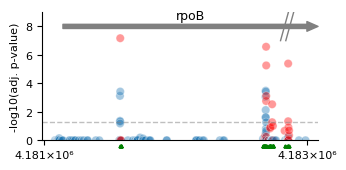

In [48]:
### look specifically at rpoB
#now using BH corrected pvals, but plotting with relaxed cutoff

# Apply filters
pval_cutoff = 1
into_plot = rif_combined_df[(rif_combined_df['stouffer_pval']<pval_cutoff)&(rif_combined_df['alt']!="-")] #(rif_combined_df['count']==3)&
### 
#import matplotlib.ticker as ticker
# filter to region of interest
xlim_start = 4181100
xlim_end = 4183100
into_plot = into_plot[into_plot['pos'].isin(range(xlim_start, xlim_end))]


# Add in_literature column to into_plot, adjusting for 0 indexing
into_plot = into_plot.copy()  # Avoid SettingWithCopyWarning
into_plot['pos'] = into_plot['pos'] +1
into_plot['in_literature'] = into_plot.apply(
    lambda row: 'Yes' if (row['pos'], row['ref'], row['alt']) in literature_mutations else 'No', 
    axis=1
)

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(BH_pval)',
    kind="scatter",
    hue='in_literature',  # Color by literature status
    height=2,
    aspect=1.7,
    alpha=0.4,
    #s = 10,
    palette=['C0', 'red'],
    legend=False
)

fontsize = 8            
g.set_axis_labels("", "-log10(adj. p-value)", fontsize=fontsize)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks([xlim_start, xlim_end])
    top = 8
    ax.set_ylim(bottom=0, top=top+1)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}×10⁶'))
    #annotate RRDRs
    for i, row in literature_muts_df.iterrows():
        ax.plot(row['pos'], -0.4, marker='^', color='green', markersize=2, clip_on=False)
    ax.plot([4182900, 4182900+60], [top-1, top+1], color='gray', linewidth=1, zorder=10) #slash to communicate discontinuous
    ax.plot([4182900+40, 4182900+60+40], [top-1, top+1], color='gray', linewidth=1, zorder=10) #slash to communicate discontinuous
    #add threshold line
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=1, alpha=0.5)
    
gene_examined = "rpoB"
plot_gene_cartoon_clipped(gene_examined, gene_df, y_position=top,
    arrow_color='gray', arrow_edge='gray', label_offset=0.5, arrow_width=3, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=9)


plt.savefig(os.path.join(fig3out, f'rpoB_rifR_adjpval{pval_cutoff}.png'), dpi=600, bbox_inches='tight')
plt.show()

In [36]:
# look at what fraction of mutations are in literature
pval_cutoff = 0.05
into_count = rif_combined_df[(rif_combined_df['BH_pval']<pval_cutoff)&(rif_combined_df['alt']!="-")] #(rif_combined_df['count']==3)&
into_count['pos'] = into_count['pos'] +1
into_count['in_literature'] = into_count.apply(
    lambda row: 'Yes' if (row['pos'], row['ref'], row['alt']) in literature_mutations else 'No', 
    axis=1
)

into_count['in_literature'].value_counts()
into_count

/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/4211619616.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  into_count['pos'] = into_count['pos'] +1
/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/4211619616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  into_count['in_literature'] = into_count.apply(


,pos,ref,alt,stouffer_pval,rep_count,all_counts,Gene,-log10(pval),BH_pval,-log10(BH_pval),in_literature
3797,60861,A,T,0.000011,2,"[516, 419]",rapA,4.954872,0.029391,1.531787,No
5348,87324,A,G,0.000015,2,"[1018, 291]",ilvI,4.822845,0.031914,1.496025,No
7467,146713,C,T,0.000041,3,"[97, 81, 120568]",intergenic_between_panD_and_rpnC,4.382382,0.047479,1.323495,No
8713,162096,G,A,0.000003,3,"[476, 386, 135]",intergenic_between_thpR_and_hrpB,5.556333,0.016648,1.778635,No
9578,182403,T,C,0.000043,3,"[351, 166, 117]",intergenic_between_degP_and_cdaR,4.363063,0.048357,1.315537,No
...,...,...,...,...,...,...,...,...,...,...,...
289259,4638121,C,A,0.000026,3,"[506, 215, 88]",creC,4.585485,0.041500,1.381949,No
289263,4638122,T,A,0.000029,3,"[385, 184, 117]",intergenic_between_creC_and_creD,4.532442,0.043163,1.364890,No
289265,4638122,T,G,0.000040,3,"[431, 238, 71]",intergenic_between_creC_and_creD,4.393493,0.047479,1.323495,No
289266,4638123,T,A,0.000030,3,"[527, 172, 102]",intergenic_between_creC_and_creD,4.521210,0.043264,1.363877,No


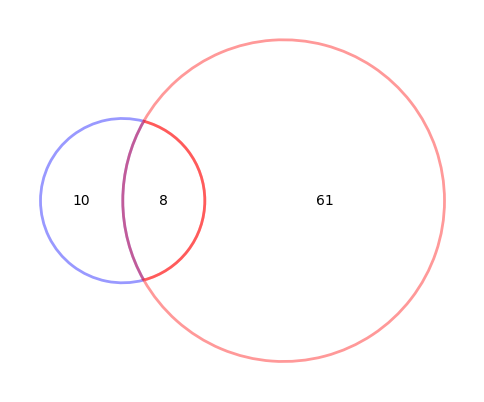

In [37]:
#visualize venn diagram of literature and non-literature mutations
#!pip install matplotlib_venn
from matplotlib_venn import venn2

#exclude indels from counts
into_count_no_indels = into_count[(into_count['alt']!="-")&(into_count['ref']!="-")]
#also confine to rpoB mutations

into_count_no_indels = into_count_no_indels[into_count_no_indels['Gene']=="rpoB"] #also confine to rpoB mutations

# Create tuple sets from both dataframes
set1 = set(into_count_no_indels[['pos', 'ref', 'alt']].itertuples(index=False, name='BB_genome_rif'))
set2 = set(literature_muts_df[['pos', 'ref', 'alt']].itertuples(index=False, name='Lit'))

plt.figure(figsize=(6, 6))
v= venn2(
    [set1, set2],
    set_labels=("", "")
)
        
# Make circles outlined only (no fill)
for patch in v.patches:
    if patch:
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
        patch.set_facecolor('none')  # or 'white' for white fill


# Color each circle differently
v.get_patch_by_id('10').set_edgecolor('blue')
v.get_patch_by_id('11').set_edgecolor('red')
v.get_patch_by_id('01').set_edgecolor('red')

plt.title("")
#plt.savefig(os.path.join(fig3out, f'rif_venn_diagram_adjpval{pval_cutoff}.pdf'), bbox_inches='tight')
plt.show()


the following produces an interactive version of the plot, which may be of interest to some readers for further exploration of the data.

In [ ]:
#trying interactive version:
import plotly.express as px

pval_cutoff = 0.001


# Filter the data
# Apply filters
into_plot = rif_combined_df[(rif_combined_df['count']==3)&(rif_combined_df['stouffer_pval']<pval_cutoff)]
# label genes, using fast method
into_plot['Gene'] = into_plot['pos'].apply(fast_annotate)
into_plot['-log10(pval)'] = -np.log10(into_plot['stouffer_pval'])
into_plot['pos_str'] = into_plot['pos'].astype(str) #string version of pos


# Generate interactive scatter plot
fig = px.scatter(
    into_plot,
    x="pos",
    y="-log10(pval)",
    title=f"Stouffer p-value <{pval_cutoff}, 3 replicates",
    labels={"pos_str": "Genomic Position", "stouffer_pval": "Stouffer p-value", "Gene": "Gene"},
    opacity=0.3,
    hover_data=into_plot.columns,  # Optional: show all columns on hover,
    width=1200,   # Width in pixels
    height=600 
)

# Optional: log-scale for p-values
#fig.update_yaxes(type="log")


# Display plot
#fig.write_html("interactive_plot_stouffer.html")
fig.show()

/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_21437/1181953882.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_21437/1181953882.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_21437/1181953882.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

now we look at natural populations, which were whole genome shotgun-sequenced in this study
this analysis begins with the variant call files output from data preparation such as lofreq etc.

In [38]:
### now as a comparison, let's look at significance (and allelic fraction) versions from whole genome shotgun sequencing

##first, pull WGS data
WGS_data_path = os.path.join(data_dir, "WGS_shotgun", "df_all_variants_WGS.csv")
WGS_data = pd.read_csv(WGS_data_path)
WGS_data

#label with metadata
WGS_metadata_path = os.path.join(data_dir, "WGS_shotgun", "WGS_and_SR_metadata.csv")
WGS_metadata = pd.read_csv(WGS_metadata_path)
##WGS_metadata

WGS_labeleddata = WGS_data.merge(WGS_metadata, on='samplenum')


#filter to rif resistance samples, both WT and mutagenic plasmid samples 
WGS_labeleddata_rif1 = WGS_labeleddata[(WGS_labeleddata['timepoint']=='0')&(WGS_labeleddata['description']=='solid material rif gDNA')]


#label WT and mutagenic plasmid, better
tx_mapping = {
    1.0: "Wild type",
    2.0: "Mutagenic plasmid"
}
WGS_labeleddata_rif1['type'] = WGS_labeleddata_rif1['tx'].map(tx_mapping)

WGS_labeleddata_rif1.drop(columns=['timepoint', 'induction', 'selection_desc', 'prep_type', 'ID', 'description','tx'], inplace=True) #drop extraneous columns
WGS_labeleddata_rif1

/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/57680647.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WGS_labeleddata_rif1['type'] = WGS_labeleddata_rif1['tx'].map(tx_mapping)
/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/57680647.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WGS_labeleddata_rif1.drop(columns=['timepoint', 'induction', 'selection_desc', 'prep_type', 'ID', 'description','tx'], inplace=True) #drop extraneous columns


,CHROM,POS,REF,ALT,QUAL,FILTER,DP,AF,SB,DP4_ref_fwd,DP4_ref_rev,DP4_alt_fwd,DP4_alt_rev,ALT_DP,samplenum,rep,type
0,U00096.3,2229,G,C,100.0,PASS,1747,0.085861,334,807,627,11,139,150,m15,A,Wild type
1,U00096.3,3274,C,A,113.0,PASS,1119,0.039321,106,551,518,43,1,44,m15,A,Wild type
2,U00096.3,6352,A,C,119.0,PASS,870,0.042529,109,410,423,37,0,37,m15,A,Wild type
3,U00096.3,6362,T,C,106.0,PASS,865,0.036994,87,434,399,32,0,32,m15,A,Wild type
4,U00096.3,6377,A,C,108.0,PASS,994,0.031187,68,563,400,31,0,31,m15,A,Wild type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12236,U00096.3,4625341,C,T,119.0,PASS,1132,0.009717,28,614,507,11,0,11,m22,D,Mutagenic plasmid
12237,U00096.3,4629949,G,C,103.0,PASS,1278,0.015649,0,700,552,11,9,20,m22,D,Mutagenic plasmid
12238,U00096.3,4629956,C,T,156.0,PASS,1218,0.019704,6,660,531,10,14,24,m22,D,Mutagenic plasmid
12239,U00096.3,4631417,C,T,386.0,PASS,1435,0.131707,355,698,536,185,4,189,m22,D,Mutagenic plasmid


In [39]:
WGS_labeleddata_rif1[WGS_labeleddata_rif1['AF']>0.7]


,CHROM,POS,REF,ALT,QUAL,FILTER,DP,AF,SB,DP4_ref_fwd,DP4_ref_rev,DP4_alt_fwd,DP4_alt_rev,ALT_DP,samplenum,rep,type
18,U00096.3,70289,G,T,49314.0,PASS,29236,0.957860,0,850,370,19599,8405,28004,m15,A,Wild type
19,U00096.3,70371,T,C,49314.0,PASS,25510,0.954371,13,707,426,15912,8434,24346,m15,A,Wild type
21,U00096.3,70434,C,T,49314.0,PASS,27311,0.958002,14,604,538,14678,11486,26164,m15,A,Wild type
23,U00096.3,70581,C,T,49314.0,PASS,29238,0.958684,26,475,724,12367,15663,28030,m15,A,Wild type
24,U00096.3,70740,T,G,49314.0,PASS,31757,0.956230,45,801,576,15917,14450,30367,m15,A,Wild type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,U00096.3,2685013,G,A,49314.0,PASS,1547,1.000000,0,0,0,671,876,1547,m22,D,Mutagenic plasmid
11547,U00096.3,2810925,G,A,49314.0,PASS,56494,0.977042,563,498,785,33741,21456,55197,m22,D,Mutagenic plasmid
11766,U00096.3,3424235,A,C,238.0,PASS,58,0.982759,0,0,1,0,57,57,m22,D,Mutagenic plasmid
11767,U00096.3,3424236,T,A,231.0,PASS,57,0.982456,0,0,1,0,56,56,m22,D,Mutagenic plasmid


In [40]:
#alternative summary for WGS data, where mutagenic and wild type are plotted separately
#and also the stouffer pval is computed

#first, discard preexisting differences to reference, which occur at very high AF
WGS_labeleddata_rif1_filtered = WGS_labeleddata_rif1[WGS_labeleddata_rif1['AF']<0.7]

#split into wild type and mutagenic plasmid
WGSrif_WT = WGS_labeleddata_rif1_filtered[WGS_labeleddata_rif1_filtered['type']=='Wild type']
WGSrif_MP = WGS_labeleddata_rif1_filtered[WGS_labeleddata_rif1_filtered['type']=='Mutagenic plasmid']
#discard mutations known to occur in the arabinose-induction mutagenesis plasmid
WGSrif_MP ['Gene'] = WGSrif_MP ['POS'].apply(fast_annotate)
WGSrif_MP  = WGSrif_MP[WGSrif_MP['Gene']!='araC']
WGSrif_MP = WGSrif_MP[WGSrif_MP['Gene']!='intergenic_between_araB_and_araC']
WGSrif_MP = WGSrif_MP[WGSrif_MP['Gene']!='dnaQ']


#compute pvals and FDR-correct, separately for wild type and mutagenic plasmid
WGSrif_WT['permutation_pval_precise_altDP'] = compute_empirical_pvals(WGSrif_WT, value_col='ALT_DP', subsample=False)
WGSrif_MP['permutation_pval_precise_altDP'] = compute_empirical_pvals(WGSrif_MP, value_col='ALT_DP', subsample=False)
#WT
WGSrif_WT_summ = WGSrif_WT.groupby(['POS', 'REF', 'ALT']).progress_apply(stouffer_wrapper, pval_col='permutation_pval_precise_altDP', count_col='AF', output_col='stouffer_pval_altDP').reset_index()
WGSrif_WT_summ['-log10(pval_altDP)'] = -np.log10(WGSrif_WT_summ['stouffer_pval_altDP'])
WGSrif_WT_summ['BH_pval_altDP'] = multipletests(WGSrif_WT_summ['stouffer_pval_altDP'], method='fdr_bh')[1]
WGSrif_WT_summ['-log10(BH_pval_altDP)'] = -np.log10(WGSrif_WT_summ['BH_pval_altDP'])
#mutagenic plasmid
WGSrif_MP_summ = WGSrif_MP.groupby(['POS', 'REF', 'ALT']).progress_apply(stouffer_wrapper, pval_col='permutation_pval_precise_altDP', count_col='AF', output_col='stouffer_pval_altDP').reset_index()
WGSrif_MP_summ['-log10(pval_altDP)'] = -np.log10(WGSrif_MP_summ['stouffer_pval_altDP'])
WGSrif_MP_summ['BH_pval_altDP'] = multipletests(WGSrif_MP_summ['stouffer_pval_altDP'], method='fdr_bh')[1]
WGSrif_MP_summ['-log10(BH_pval_altDP)'] = -np.log10(WGSrif_MP_summ['BH_pval_altDP'])



WGSrif_WT_summ


/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/2262975221.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WGSrif_MP ['Gene'] = WGSrif_MP ['POS'].apply(fast_annotate)


Using null distribution of size: 5365


100%|██████████| 5365/5365 [00:02<00:00, 2518.66it/s]
/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/2262975221.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WGSrif_WT['permutation_pval_precise_altDP'] = compute_empirical_pvals(WGSrif_WT, value_col='ALT_DP', subsample=False)


Using null distribution of size: 6675


100%|██████████| 4043/4043 [00:02<00:00, 1595.19it/s]


,POS,REF,ALT,stouffer_pval_altDP,rep_count,all_counts,-log10(pval_altDP),BH_pval_altDP,-log10(BH_pval_altDP)
0,1545,T,C,0.632123,2,"[0.022883, 0.02725]",0.199198,1.000000,-0.000000
1,2229,G,C,0.000535,4,"[0.085861, 0.107223, 0.121324, 0.100276]",3.272047,0.031257,1.505056
2,2353,G,T,0.956019,1,[0.007506],0.019533,1.000000,-0.000000
3,3262,G,T,0.644987,1,[0.028693],0.190449,1.000000,-0.000000
4,3274,C,A,0.426761,1,[0.039321],0.369815,1.000000,-0.000000
...,...,...,...,...,...,...,...,...,...
3249,4631067,G,A,0.909989,1,[0.00823],0.040964,1.000000,-0.000000
3250,4631417,C,T,0.001045,4,"[0.10873, 0.100676, 0.13104, 0.119231]",2.980978,0.046054,1.336728
3251,4635280,A,G,0.783079,1,[0.007679],0.106195,1.000000,-0.000000
3252,4639564,G,T,0.249907,1,[0.06359],0.602222,1.000000,-0.000000


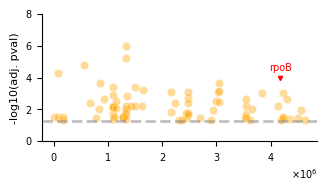

In [44]:
### full genome view, using WGS data


# Apply filters
into_plot = WGSrif_WT_summ.copy()

pval_cutoff = 0.05
into_plot = into_plot[(into_plot['BH_pval_altDP']<pval_cutoff)]

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="POS",
    y='-log10(BH_pval_altDP)',
    kind="scatter",
    color = 'orange',
    #col = 'type',  # Color by experiment type
    height=2,
    aspect=1.7,
    alpha=0.4,
    #palette=[ plt.get_cmap('Dark2')(1)], #color differently than literature indicator plt.get_cmap('Set2')(0),
    legend=False
)

fontsize = 8                 
g.set_axis_labels("", '-log10(adj. pval)', fontsize=fontsize)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=8)
    ax.xaxis.offsetText.set_fontsize(fontsize-1)
    ax.tick_params(labelsize=7)
    #ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}E6'))
    #annotate RRDRs
    #for i, row in literature_muts_df.iterrows():
    ax.plot(4181100, 4, marker='v', color='red', markersize=3, clip_on=False)
    ax.text(4181100, 4 + 0.3, "rpoB", color='red', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    #add threshold line
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)
    #customize x-axis formatter
    ax.ticklabel_format(axis="x", style="sci", scilimits=(6, 6))
    ax.xaxis.get_major_formatter().set_useMathText(True)
    
gene_examined = "rpoB"
#plot_gene_cartoon_clipped(gene_examined, gene_info_df, y_position=.5,
#    arrow_color='gray', arrow_edge='gray', label_offset=.05, arrow_width=5, arrow_headwidth=10, arrow_headlength=10, gene_name_fontsize=9)


plt.savefig(os.path.join(fig3out, f'WGS_WT_fullgenome_rifR_-log_adjpval{pval_cutoff}.png'), dpi=600, bbox_inches='tight')
plt.show()

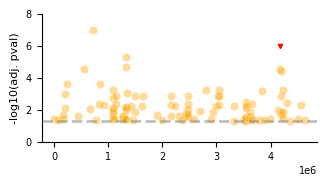

In [108]:
##identifical to above plot, but with mutagenic plasmid data

### full genome view, using WGS data hmm


# Apply filters
into_plot = WGSrif_MP_summ.copy()

pval_cutoff = 0.05
into_plot = into_plot[(into_plot['BH_pval_altDP']<pval_cutoff)]

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="POS",
    y='-log10(BH_pval_altDP)',
    kind="scatter",
    color = 'orange',
    #col = 'type',  # Color by experiment type
    height=2,
    aspect=1.7,
    alpha=0.4,
    #palette=[ plt.get_cmap('Dark2')(1)], #color differently than literature indicator plt.get_cmap('Set2')(0),
    legend=False
)

fontsize = 8                 
g.set_axis_labels("", '-log10(adj. pval)', fontsize=fontsize)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=8)
    ax.xaxis.offsetText.set_fontsize(fontsize-1)
    ax.tick_params(labelsize=7)
    #ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}E6'))
    #annotate RRDRs
    #for i, row in literature_muts_df.iterrows():
    ax.plot(4181100, 6, marker='v', color='red', markersize=3, clip_on=False)
    #add threshold line
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)
    
gene_examined = "rpoB"
#plot_gene_cartoon_clipped(gene_examined, gene_info_df, y_position=.5,
#    arrow_color='gray', arrow_edge='gray', label_offset=.05, arrow_width=5, arrow_headwidth=10, arrow_headlength=10, gene_name_fontsize=9)


plt.savefig(os.path.join(fig3out, f'WGS_MP_fullgenome_rifR_-log_adjustedp.png'), dpi=600, bbox_inches='tight')
plt.show()

In [82]:
WGSrif_MP_summ

,POS,REF,ALT,stouffer_pval_altDP,rep_count,all_counts,-log10(pval_altDP),BH_pval_altDP,-log10(BH_pval_altDP)
0,1545,T,C,0.486504,1,[0.028131],0.312913,0.995492,0.001962
1,2229,G,C,0.000502,4,"[0.095707, 0.10441, 0.091628, 0.111176]",3.299593,0.023133,1.635764
2,2887,T,C,0.993542,1,[0.010127],0.002814,0.999701,0.000130
3,3251,A,C,0.360490,1,[0.031756],0.443107,0.995492,0.001962
4,3274,C,A,0.177274,2,"[0.037585, 0.054688]",0.751354,0.995492,0.001962
...,...,...,...,...,...,...,...,...,...
4053,4638214,C,A,0.511177,1,[0.0271],0.291428,0.995492,0.001962
4054,4639564,G,T,0.191720,2,"[0.065947, 0.046895]",0.717334,0.995492,0.001962
4055,4640649,A,G,0.902716,1,[0.007597],0.044449,0.995492,0.001962
4056,4641105,T,C,0.993542,1,[0.008222],0.002814,0.999701,0.000130


this interactive plot is not shown in the publication but may be of interest to some readers for further exploration of the data.

In [99]:
#interactive plot to examine mutation hotspots
#trying interactive version:
import plotly.express as px

pval_cutoff = 0.05


# Filter the data
# Apply filters
into_plot = WGSrif_MP_summ.copy()
into_plot = into_plot[(into_plot['BH_pval_altDP']<pval_cutoff)]
# label genes, using fast method
into_plot['Gene'] = into_plot['POS'].apply(fast_annotate)
#into_plot['-log10(pval)'] = -np.log10(into_plot['stouffer_pval'])
into_plot['pos_str'] = into_plot['POS'].astype(str) #string version of pos


# Generate interactive scatter plot
fig = px.scatter(
    into_plot,
    x="POS",
    y='-log10(BH_pval_altDP)',
    title=f"Adjusted p-value <{pval_cutoff}",
    labels={"pos_str": "Genomic Position", "-log10(BH_pval_altDP)": "-log10 adjusted p-value", "Gene": "Gene"},
    opacity=0.3,
    hover_data=into_plot.columns,  # Optional: show all columns on hover,
    width=1200,   # Width in pixels
    height=600 
)

# Optional: log-scale for p-values
#fig.update_yaxes(type="log")


# Display plot
#fig.write_html("interactive_plot_stouffer.html")
fig.show()


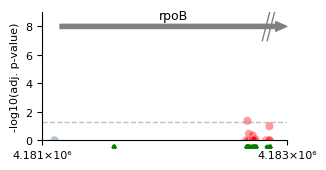

In [49]:
### look specifically at rpoB, using WGS data hmm
#looking at wild type data here only for simplicity


# Apply filters
into_plot = WGSrif_WT_summ.copy()

#import matplotlib.ticker as ticker
# filter to region of interest
xlim_start = 4181100
xlim_end = 4183100
into_plot = into_plot[into_plot['POS'].isin(range(xlim_start, xlim_end))]


# Add in_literature column to into_plot, adjusting for 0 indexing
#into_plot = into_plot.copy()  # Avoid SettingWithCopyWarning
#into_plot['POS'] = into_plot['POS'] +1
into_plot['in_literature'] = into_plot.apply(
    lambda row: 'Yes' if (row['POS'], row['REF'], row['ALT']) in literature_mutations else 'No',axis=1)

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="POS",
    y='-log10(BH_pval_altDP)',
    kind="scatter",
    hue='in_literature',
    #col = 'type',  # Color by experiment type
    height=2,
    aspect=1.7,
    alpha=0.4,
    #s = 5,
    palette=['C0', 'red'], #[plt.get_cmap('Set2')(0), plt.get_cmap('Dark2')(1)],
    legend=False
)


fontsize = 8 
g.set_axis_labels("", "-log10(adj. p-value)", fontsize=fontsize)
#g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    top = 8 ### caution: make sure you are not clipping data!
    ax.set_ylim(bottom=0, top= top+1) 
    ax.set_xlim(xlim_start, xlim_end)  #
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks([xlim_start, xlim_end])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}×10⁶'))
    #annotate RRDRs
    for i, row in literature_muts_df.iterrows():
        ax.plot(row['pos'], -0.4, marker='^', color='green', markersize=2, clip_on=False)
    ax.plot([4182900, 4182900+60], [top-1, top+1], color='gray', linewidth=1, zorder=10) #slash to communicate discontinuous
    ax.plot([4182900+40, 4182900+60+40], [top-1, top+1], color='gray', linewidth=1, zorder=10) #slash to communicate discontinuous
    #add threshold line
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=1, alpha=0.5)

gene_examined = "rpoB"
plot_gene_cartoon_clipped(gene_examined, gene_df, y_position=top,
    arrow_color='gray', arrow_edge='gray', label_offset=0.5, arrow_width=3, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=9)


plt.savefig(os.path.join(fig3out, f'WGS_rpoB_WTrifR.png'), dpi=600, bbox_inches='tight')
plt.show()




In [52]:
## how many muations detected, total?
into_plot.shape[0]

24

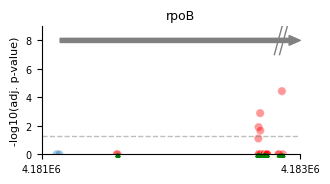

In [120]:
### same plot, but with mutagenic plasmid data


# Apply filters
into_plot = WGSrif_MP_summ.copy()

#import matplotlib.ticker as ticker
# filter to region of interest
xlim_start = 4181100
xlim_end = 4183100
into_plot = into_plot[into_plot['POS'].isin(range(xlim_start, xlim_end))]


# Add in_literature column to into_plot, adjusting for 0 indexing
#into_plot = into_plot.copy()  # Avoid SettingWithCopyWarning
#into_plot['POS'] = into_plot['POS'] +1
into_plot['in_literature'] = into_plot.apply(
    lambda row: 'Yes' if (row['POS'], row['REF'], row['ALT']) in literature_mutations else 'No',axis=1)

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="POS",
    y='-log10(BH_pval_altDP)',
    kind="scatter",
    hue='in_literature',
    #col = 'type',  # Color by experiment type
    height=2,
    aspect=1.7,
    alpha=0.4,
    #s = 5,
    palette=['C0', 'red'], #[plt.get_cmap('Set2')(0), plt.get_cmap('Dark2')(1)],
    legend=False
)


fontsize = 8 
g.set_axis_labels("", "-log10(adj. p-value)", fontsize=fontsize)
#g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    top = 8
    ax.set_ylim(bottom=0, top= top+1)
    offset = 0.3
    #ax.set_ylim(bottom=0, top=ylim_top+offset+0.01) ### caution: make sure you are not clipping data!
    ax.set_xlim(xlim_start, xlim_end)  #
    ax.tick_params(labelsize=7)
    ax.set_xticks([xlim_start, xlim_end])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}E6'))
    #annotate RRDRs
    for i, row in literature_muts_df.iterrows():
        ax.plot(row['pos'], -0.06, marker='^', color='green', markersize=2, clip_on=False)
    ax.plot([4182900, 4182900+60], [top-1, top+1], color='gray', linewidth=1, zorder=10) #slash to communicate discontinuous
    ax.plot([4182900+40, 4182900+60+40], [top-1, top+1], color='gray', linewidth=1, zorder=10) #slash to communicate discontinuous
    #add threshold line
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=1, alpha=0.5)

gene_examined = "rpoB"
plot_gene_cartoon_clipped(gene_examined, gene_df, y_position=top,
    arrow_color='gray', arrow_edge='gray', label_offset=1.5, arrow_width=3, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=9)


plt.savefig(os.path.join(fig3out, f'WGS_rpoB_MPrifR.png'), dpi=600, bbox_inches='tight')
plt.show()


In [199]:
#venn diagram for WGS data
into_plot['in_literature'].value_counts()

in_literature
Yes    25
No      2
Name: count, dtype: int64

Next, to help explain differences between these methods, we want to help give the reader some intuition about the ways in which these methods differ

one of which is the number of mutations contained when you make mutations given natural mutation, added mutagen/mutagenesis, and the barcoded mutations created with biobloom  

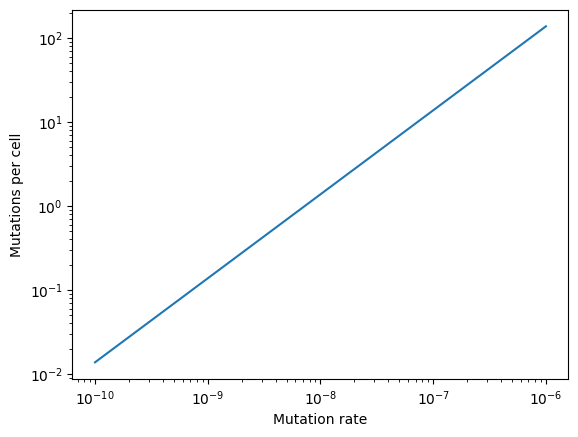

In [121]:
####

### separate model: predicting how many mutations are present, per cell, for each of 
#1. Biobloom
#2. Natural mutation
#3. Mutagenic population

#first, let's address 2&3 with a simple model varying mutation rate
population_size = 1e9 #typical number of cells
genome_size=4.6e6

# Number of doublings to reach N cells from 1 cell:
generations = np.log2(population_size)

#loop across a range of mutation rates
mut_rates = np.logspace(-10, -6, 20)
mutations_per_cell = []
mut_rates_plot = []
for mut_rate in mut_rates:
    mut_rates_plot.append(mut_rate)
    #mutations per cell
    mutations_per_cell.append(generations * mut_rate * genome_size)


plt.plot(mut_rates, mutations_per_cell)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mutation rate')
plt.ylabel(f'Mutations per cell')
plt.show()


In [56]:
# to get the actual distribution, incorporate poisson sampling

#first, let's address 2&3 with a simple model varying mutation rate
population_size = 1e9 #typical number of cells
genome_size=4.6e6


def simulate_mutations(
    population_size,
    genome_size=4.6e6,
    mutation_rate=1e-10,
    n_sim=100000
):
    """
    Simulates the number of mutations accumulated in cell lineages.
    Assumes Poisson-distributed mutation counts per replication.
    """

    generations = np.log2(population_size)
    print(f"generations elapsed: {generations}")
    lambda_per_gen = genome_size * mutation_rate

    # Expected total rate over the lineage:
    lam = generations * lambda_per_gen

    # Draw Poisson-distributed mutation counts
    return np.random.poisson(lam, size=n_sim)

# example for natural mutation
dist_natural = simulate_mutations(population_size, mutation_rate=1e-10)

dist_natural
#print("Mean mutations:", dist.mean())
#print("P(mutations=0):", np.mean(dist == 0))
#print("P(mutations=1):", np.mean(dist == 1))

generations elapsed: 29.897352853986263


array([0, 0, 0, ..., 0, 0, 0], shape=(100000,))

generations elapsed: 29.897352853986263
Fractions:
0: 0.974450
1: 0.025160
2: 0.000390
3: 0.000000
4: 0.000000
5+: 0.000000


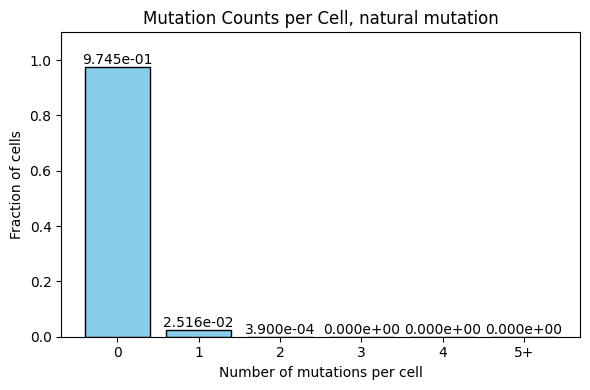

In [57]:

dist_natural = simulate_mutations(population_size, mutation_rate=1.88e-10) #https://pmc.ncbi.nlm.nih.gov/articles/PMC3478608/
into_plot = dist_natural
# Compute fractions
frac_0 = np.mean(into_plot == 0)
frac_1 = np.mean(into_plot == 1)
frac_2 = np.mean(into_plot == 2)
frac_3 = np.mean(into_plot == 3)
frac_4 = np.mean(into_plot == 4)
frac_5p = np.mean(into_plot >= 5)

fractions = [frac_0, frac_1, frac_2, frac_3, frac_4, frac_5p]
labels = ["0", "1", "2", "3", "4","5+"]

print("Fractions:")
for lbl, val in zip(labels, fractions):
    print(f"{lbl}: {val:.6f}")

# --- Plot ---
plt.figure(figsize=(6,4))
plt.bar(labels, fractions, color='skyblue', edgecolor='k')
plt.ylabel("Fraction of cells")
plt.xlabel("Number of mutations per cell")
plt.title("Mutation Counts per Cell, natural mutation")
plt.ylim(0, 1.1)

for i, v in enumerate(fractions):
    plt.text(i, v + 0.01*max(fractions), f"{v:.3e}", ha='center')

plt.tight_layout()
plt.show()


generations elapsed: 29.897352853986263
Fractions:
0: 0.000000
1: 0.000000
2: 0.000000
3: 0.000000
4: 0.000000
5+: 1.000000


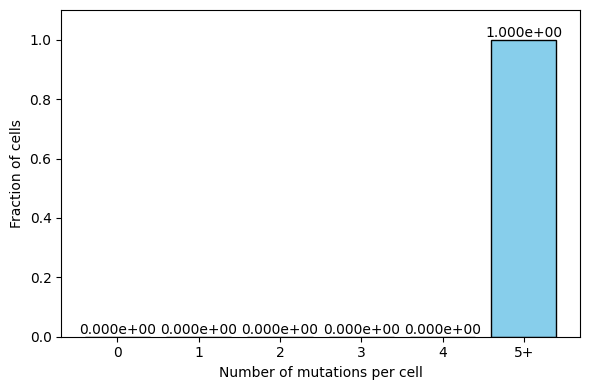

In [58]:
# simulation for mutagenic population

dist_mutagenic = simulate_mutations(population_size, mutation_rate=326e-8) #https://pmc.ncbi.nlm.nih.gov/articles/PMC3478608/

into_plot = dist_mutagenic

# Compute fractions
frac_0 = np.mean(into_plot == 0)
frac_1 = np.mean(into_plot == 1)
frac_2 = np.mean(into_plot == 2)
frac_3 = np.mean(into_plot == 3)
frac_4 = np.mean(into_plot == 4)
frac_5p = np.mean(into_plot >= 5)

fractions = [frac_0, frac_1, frac_2, frac_3, frac_4, frac_5p]
labels = ["0", "1", "2", "3", "4","5+"]

print("Fractions:")
for lbl, val in zip(labels, fractions):
    print(f"{lbl}: {val:.6f}")

# --- Plot ---
plt.figure(figsize=(6,4))
plt.bar(labels, fractions, color='skyblue', edgecolor='k')
plt.ylabel("Fraction of cells")
plt.xlabel("Number of mutations per cell")
#plt.title("Mutation Counts per Cell, ~100x mutation rate")
plt.ylim(0, max(fractions)*1.2)
plt.ylim(0, 1.1)

for i, v in enumerate(fractions):
    plt.text(i, v + 0.01*max(fractions), f"{v:.3e}", ha='center')

plt.tight_layout()
plt.show()

In [59]:
### specify biobloom characteristics in model

#first, let's address 2&3 with a simple model varying mutation rate
population_size = 1e9 #typical number of cells
genome_size=4.6e6


def simulate_offtarget_mutations_biobloom(
    
    #biobloom 
    gens_editing = 15, #more mutagenesis while editing
    gens_not_editing = 5,
    genome_size=4.6e6,
    mutation_rate_edit=326e-10, #https://pmc.ncbi.nlm.nih.gov/articles/PMC3478608/
    mutation_rate_not_edit=1.88e-10,
    n_sim=100000
):
    """
    Simulates the number of mutations accumulated in cell lineages when a biobloom method is used.

    gens_editing: number of generations of editing at mutL mutation rate
    population_size: number of cells
    genome_size: size of the genome
    mutation_rate: mutation rate of the mutL allele
    n_sim: number of simulations to run

    Assumes Poisson-distributed mutation counts per replication.
    """

    lambda_per_gen_edit = genome_size * mutation_rate_edit
    lambda_per_gen_not_edit = genome_size * mutation_rate_not_edit

    # Expected total rate over the lineage:
    lam = gens_editing * lambda_per_gen_edit + gens_not_editing * lambda_per_gen_not_edit

    # Draw Poisson-distributed mutation counts, from random mutations
    random_mutations = np.random.poisson(lam, size=n_sim)
    
    return random_mutations

# biobloom simulation
dist_biobloom = simulate_offtarget_mutations_biobloom(
    gens_editing = 16,
    gens_not_editing = 4,
    mutation_rate_edit=326e-10, mutation_rate_not_edit=1.88e-10)

Fractions:
0: 0.089240
1: 0.216180
2: 0.262930
3: 0.210300
4: 0.124890
5+: 0.096460


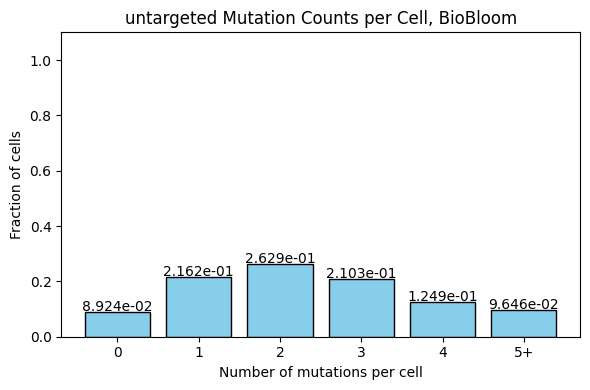

In [60]:
# 
# simulation for biobloomddddd population
into_plot = dist_biobloom

# Compute fractions
frac_0 = np.mean(into_plot == 0)
frac_1 = np.mean(into_plot == 1) #+ 0.5
frac_2 = np.mean(into_plot == 2)
frac_3 = np.mean(into_plot == 3)
frac_4 = np.mean(into_plot == 4)
frac_5p = np.mean(into_plot >= 5)

fractions = [frac_0, frac_1, frac_2, frac_3, frac_4, frac_5p]
labels = ["0", "1", "2", "3", "4","5+"]

print("Fractions:")
for lbl, val in zip(labels, fractions):
    print(f"{lbl}: {val:.6f}")

# --- Plot ---
plt.figure(figsize=(6,4))
plt.bar(labels, fractions, color='skyblue', edgecolor='k')
plt.ylabel("Fraction of cells")
plt.xlabel("Number of mutations per cell")
plt.title("untargeted Mutation Counts per Cell, BioBloom")
plt.ylim(0, 1.1)

for i, v in enumerate(fractions):
    plt.text(i, v + 0.01*max(fractions), f"{v:.3e}", ha='center')

plt.tight_layout()
plt.show()


/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/1092603928.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3')


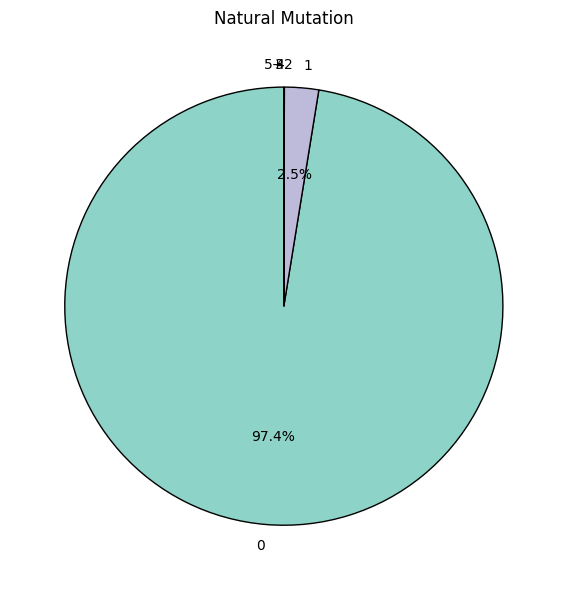

In [61]:
### pie chart version, natural mutations
import matplotlib.cm as cm
import matplotlib.colors as colors

def autopct_if_big(pct):
    return f"{pct:.1f}%" if pct >= 0.1 else ""   # hide if < 0.1%

into_plot = dist_natural

# Compute fractions
frac_0 = np.mean(into_plot == 0)
frac_1 = np.mean(into_plot == 1)
frac_2 = np.mean(into_plot == 2)
frac_3 = np.mean(into_plot == 3)
frac_4 = np.mean(into_plot == 4)
frac_5p = np.mean(into_plot >= 5)

fractions = [frac_0, frac_1, frac_2, frac_3, frac_4, frac_5p]
labels = ["0", "1", "2", "3", "4","5+"]

# Choose a ColorBrewer palette (Set3 has many distinct colors)
cmap = cm.get_cmap('Set3')

# Pick N colors spaced evenly through the palette
colors_list = [cmap(i) for i in np.linspace(0, 1, len(fractions))]

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    fractions,
    labels=labels,
    autopct=autopct_if_big,
    startangle=90,
    colors=colors_list,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Natural Mutation")
plt.tight_layout()

plt.savefig(os.path.join(fig3out, "natural_mutation_pie.pdf"), bbox_inches="tight", transparent=True)

plt.show()

generations elapsed: 29.897352853986263


/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/3373594184.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3')


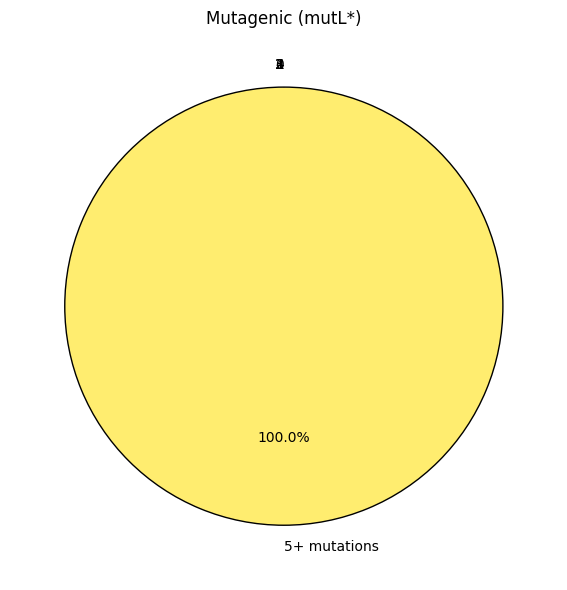

In [62]:
### pie chart version, mutL mutations
import matplotlib.cm as cm
import matplotlib.colors as colors

dist_mutagenic = simulate_mutations(population_size, mutation_rate=326e-8)

def autopct_if_big(pct):
    return f"{pct:.1f}%" if pct >= 0.1 else ""   # hide if < 0.1%

into_plot = dist_mutagenic

# Compute fractions
frac_0 = np.mean(into_plot == 0)
frac_1 = np.mean(into_plot == 1)
frac_2 = np.mean(into_plot == 2)
frac_3 = np.mean(into_plot == 3)
frac_4 = np.mean(into_plot == 4)
frac_5p = np.mean(into_plot >= 5)

fractions = [frac_0, frac_1, frac_2, frac_3, frac_4, frac_5p]
labels = ["0", "1", "2", "3", "4","5+ mutations"]

# Choose a ColorBrewer palette (Set3 has many distinct colors)
cmap = cm.get_cmap('Set3')

# Pick N colors spaced evenly through the palette
colors_list = [cmap(i) for i in np.linspace(0, 1, len(fractions))]

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    fractions,
    labels=labels,
    autopct=autopct_if_big,
    startangle=90,
    colors=colors_list,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Mutagenic (mutL*)")
plt.tight_layout()

plt.savefig(os.path.join(fig3out, "mutagenic_pie.pdf"), bbox_inches="tight", transparent=True)

plt.show()

/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_87362/777790682.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3')


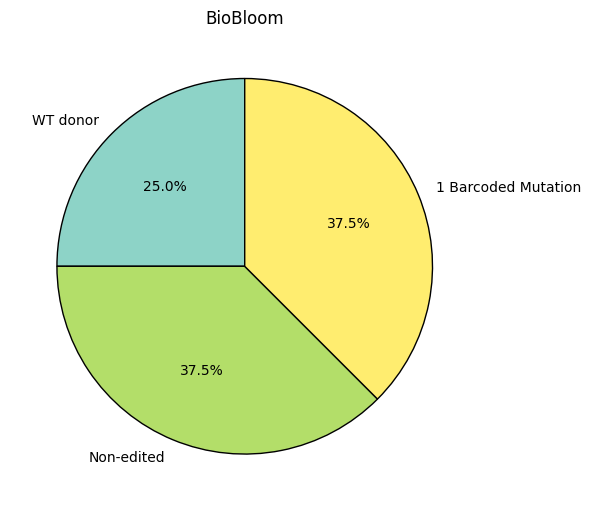

In [64]:
## biobloom targeted, mockup to describe fraction of barcodes mutated

# Compute fractions
frac_WT = 0.25
frac_0 = 0.375
frac_1 = 0.375

fractions = [frac_WT, frac_0, frac_1]
labels = ["WT donor", "Non-edited", "1 Barcoded Mutation"]

# Choose a ColorBrewer palette (Set3 has many distinct colors)
cmap = cm.get_cmap('Set3')

# Pick N colors spaced evenly through the palette
colors_list = [cmap(i) for i in np.linspace(0, 1, len(fractions))]

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    fractions,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors_list,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("BioBloom")
plt.tight_layout()

plt.savefig(os.path.join(fig3out, "Biobloom_barcode_pie.pdf"), bbox_inches="tight", transparent=True)

plt.show()

In [133]:
### pie chart version, biobloom untargeted mutations
import matplotlib.cm as cm
import matplotlib.colors as colors

dist_biobloom  = simulate_mutations_biobloom(
    gens_editing = 16,
    gens_not_editing = 4,
    mutation_rate_edit=326e-10, mutation_rate_not_edit=1.88e-10)

into_plot = dist_biobloom

# Compute fractions
frac_0 = np.mean(into_plot == 0)
frac_1 = np.mean(into_plot == 1)
frac_2 = np.mean(into_plot == 2)
frac_3 = np.mean(into_plot == 3)
frac_4 = np.mean(into_plot == 4)
frac_5p = np.mean(into_plot >= 5)

fractions = [frac_0, frac_1, frac_2, frac_3, frac_4, frac_5p]
labels = ["0", "1", "2", "3", "4","5+"]

# Choose a ColorBrewer palette (Set3 has many distinct colors)
cmap = cm.get_cmap('Set3')

# Pick N colors spaced evenly through the palette
colors_list = [cmap(i) for i in np.linspace(0, 1, len(fractions))]

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    fractions,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors_list,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Mutation Count Distribution")
plt.tight_layout()
plt.show()

NameError: name 'simulate_mutations_biobloom' is not defined